# Deriving water balance on irrigated farms using remote sensing images

## This notebook demonstrates how to estimate Actual Evapo-Transpiration (AET) using the [CMRSET methodology](https://www.wateraccounting.org/files/guerschman_j%20_of_hydr.pdf)

#### [Example](https://www.waterconnect.sa.gov.au/Content/Publications/DEW/DEWNR-TN-2016-10.pdf) of application of this methodology:


### 1.- Load datacube environment

In [1]:
import xarray as xr
import numpy as np
from datetime import date, timedelta

import datacube

dc = datacube.Datacube(app="watersense_irrigated")

### 2.- Define location and query parameters

In [2]:
locs = {"Norwood": {"coords": [149.7543738, -29.3741845]},
        "Redbank": {"coords": [150.0313090, -29.4199982]}}

coords = locs["Norwood"]["coords"]

query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'time':("2020-09-01", "2021-01-01")}

# Scale values between 0-1
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)/10000

ds

<xarray.Dataset>
Dimensions:       (time: 7, x: 443, y: 499)
Coordinates:
  * time          (time) datetime64[ns] 2020-09-03T23:55:03.484048 ... 2020-1...
  * y             (y) float64 -3.305e+06 -3.305e+06 ... -3.318e+06 -3.318e+06
  * x             (x) float64 1.693e+06 1.693e+06 ... 1.704e+06 1.704e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float64 0.0989 0.1016 0.1023 ... 0.0931 0.0932
    nbart_green   (time, y, x) float64 0.0832 0.0841 0.085 ... 0.0754 0.0756
    nbart_blue    (time, y, x) float64 0.0659 0.0663 0.0662 ... 0.0571 0.0567
    nbart_nir     (time, y, x) float64 0.1545 0.1566 0.1574 ... 0.1464 0.1463
    nbart_swir_1  (time, y, x) float64 0.1949 0.2036 0.2096 ... 0.2081 0.2084
    nbart_swir_2  (time, y, x) float64 0.1519 0.1648 0.1718 ... 0.1674 0.1685
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### 3.- Plot the RGB query results

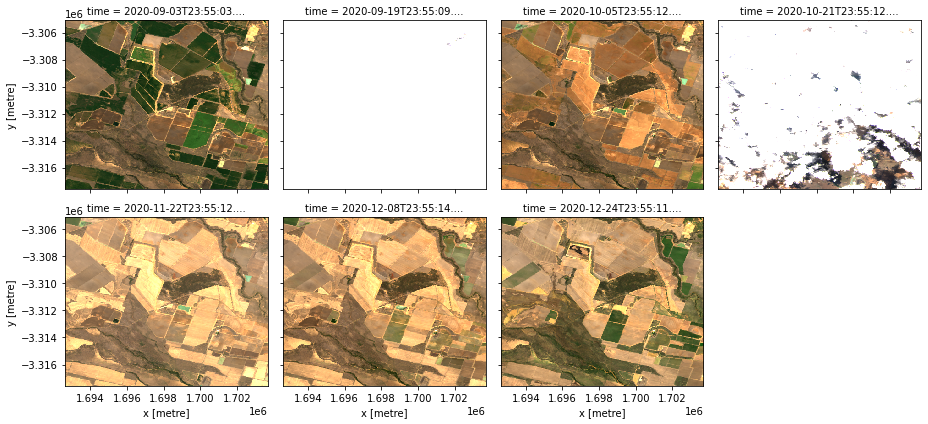

In [4]:
ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)

### 4.- Select cloud free samples, one per month, and show results

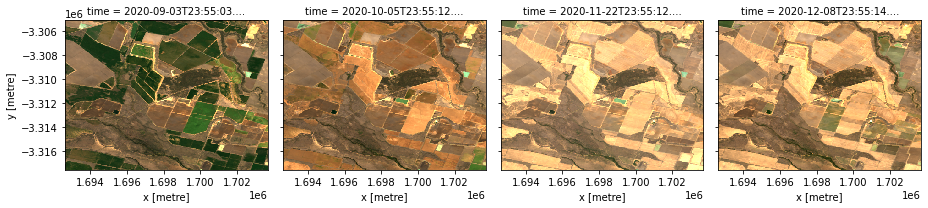

In [5]:
ds = ds.isel(time=[0,2,4,5])

ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)

### 5.- Defining our custom functions using DEA data. NDVI Example

##### NDVI = (NIR - RED) / (NIR + RED)

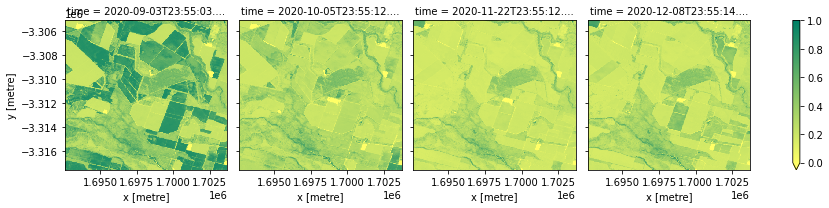

In [6]:
def ndvi(dataset):
    return (dataset.nbart_nir - dataset.nbart_red) / (dataset.nbart_nir + dataset.nbart_red)

ndvi(ds).plot(col='time', col_wrap=4, cmap="summer_r", vmin=0, vmax=1)

#### Do you know what are the bright yellow patches?

### 6.- WOfS dataset

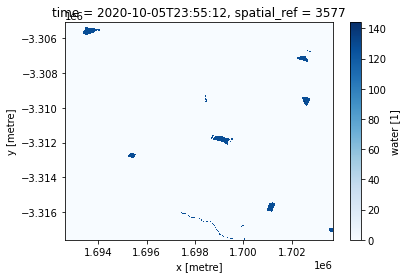

In [7]:
query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         #'time':("2018-04-01", "2018-04-10")}
         'time':("2020-10-01", "2020-10-10")}

ds_wofs = dc.load(product='wofs_albers', **query)

ds_wofs.water.plot(cmap="Blues")

### 7.- Our own version of WOfS with NDVI thresholding

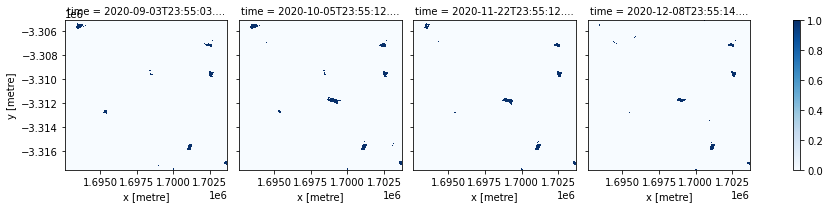

In [8]:
(ndvi(ds)<0).plot(cmap="Blues", col='time', col_wrap=4)

#### Adding all the images together

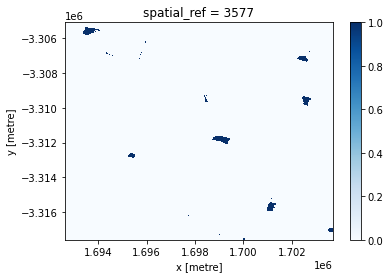

In [9]:
((ndvi(ds)<0).sum(dim="time")>1).plot(cmap="Blues")

### 8.- Enhanced Vegetation Index (EVI) (Huete et al., 2002) and improved version of NDVI

#### While the EVI is calculated similarly to NDVI, it corrects for some distortions in the reflected light caused by the particles in the air as well as the ground cover below the vegetation. The EVI data product also does not become saturated as easily as the NDVI when viewing dense forests.

##### EVI = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)

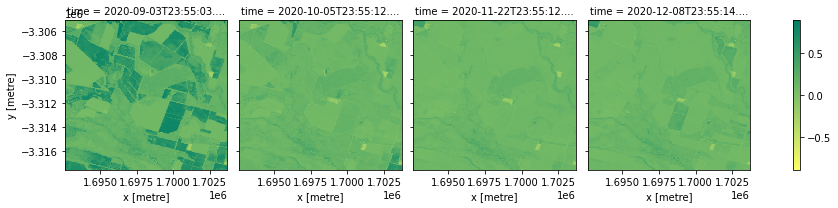

In [10]:
def evi(ds):
    G = 2.5
    C1 = 6
    C2 = 7.5
    L = 1

    return G * (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + C1 * ds.nbart_red - C2 * ds.nbart_blue + L)

evi(ds).plot(col='time', col_wrap=4, cmap="summer_r")

### 9.- EVIr a rescaled version of EVI

##### EVIr = min(1, max(0, EVI/0.9 ))

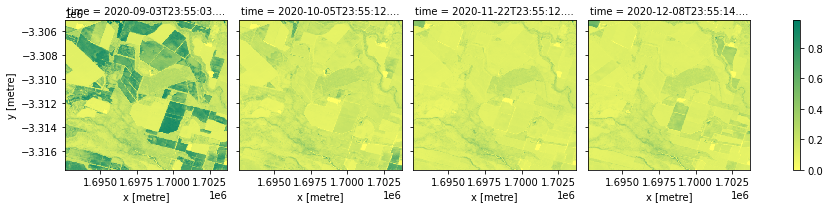

In [11]:
def evir(ds):
    return np.clip(evi(ds)/0.9, 0, 1)

evir(ds).plot(col='time', col_wrap=4, cmap="summer_r")

### 10.- Global Vegetation Moisture Index (GVMI) (Ceccato et al., 2002)

##### GVMI=((NIR+0.1)-(SWIR+0.02)) / ((NIR+0.1)+(SWIR+0.02))

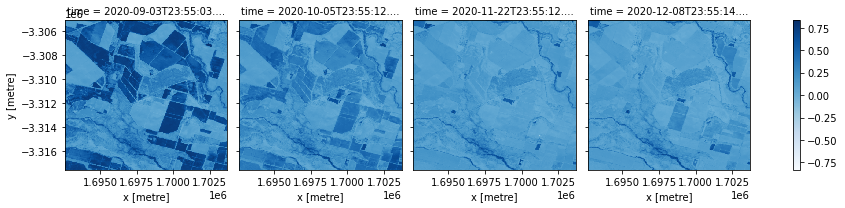

In [12]:
def gvmi(ds):
    return ((ds.nbart_nir + .1) - (ds.nbart_swir_2 + .02)) / ((ds.nbart_nir + .1) + (ds.nbart_swir_2 + .02))

gvmi(ds).plot(col='time', col_wrap=4, cmap="Blues")

### 11.- Residual Moisture Index (RMI)

##### combinines the Enhanced Vegetation Index (EVI)  and the Global Vegetation Moisture Index (GVMI)

##### RMI = min(1, max(0, GVMI - (0.775*EVI-0.0757)))

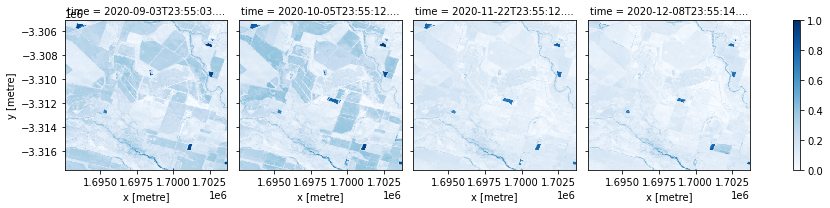

In [13]:
def rmi(ds):
    return np.clip(gvmi(ds) - (0.775 * evi(ds) - 0.0757), 0, 1)

rmi(ds).plot(col='time', col_wrap=4, cmap="Blues")

### 12.- Crop factor kc

##### The crop’s water use can be determined by multiplying an estimated PET by a crop coefficient, Kc, which takes into account the difference in ET between the crop and reference evapotranspiration.

##### ET = PET * Kc

##### The crop coefficients, Kc values, represent the crop type and the development of the crop. There may be several Kc values for a single crop depending on the crop’s stage of development.

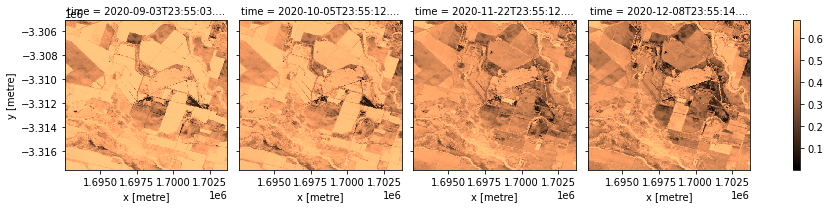

In [14]:
def kc(ds):
    c1 = 0.680
    c2 = -14.12
    c3 = 2.482
    c4 = -7.991
    c5 = 0.890

    return c1 * (1 - np.exp(c2 * np.power(evir(ds), c3) + c4 * np.power(rmi(ds), c5)))

kc(ds).plot(col='time', col_wrap=4, cmap="copper")

### Adding climate variables

### 13.- Potential Evapotranspiration (PET) from BoM online servers

[AWRA BoM page](http://www.bom.gov.au/water/landscape/)

In [15]:
ds_pet = xr.open_dataset("http://www.bom.gov.au/jsp/awra/thredds/dodsC/AWRACMS/values/month/e0.nc", decode_times=False)

ds_pet

<xarray.Dataset>
Dimensions:      (latitude: 681, longitude: 841, nv: 2, time: 261)
Coordinates:
  * time         (time) int32 36554 36583 36614 36644 ... 44406 44437 44459
  * longitude    (longitude) float64 112.0 112.0 112.1 ... 153.9 153.9 154.0
  * latitude     (latitude) float64 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) int32 ...
    e0           (time, latitude, longitude) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    var_name:                        e0
    title:                           Australian Landscape Water Balance AWRA-...
    Description:                     This data is provided by the Bureau of M...
    summary:                         Data produced by Bureau of Meteorology A...
    source:                          AWRA-L
    date_created:                    2021-09-22T18:53:27
    Conventions:                     CF-1.6, ACDD-1.3
    institution:                     Bureau of Meteorology
    email:                           awrams@bom.gov.au
    url:                             http://www.bom.gov.au/water/landscape
    date_modified:                   2021-09-22T18:55:06
    DODS_EXTRA.Unlimited_Dimension:  time

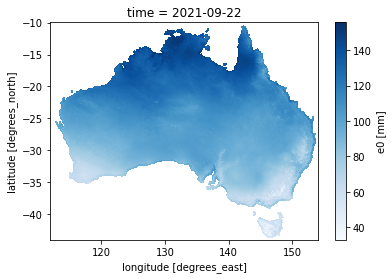

In [16]:
base = date(1900, 1, 1)
ds_pet['time'] = [np.datetime64(base + timedelta(days=int(x))) for x in ds_pet.time.values]

ds_pet.e0.isel(time=-1).plot(cmap="Blues")

### 14.- Selecting the grid point corresponding to our location

In [17]:
ds.time

<xarray.DataArray 'time' (time: 4)>
array(['2020-09-03T23:55:03.484048000', '2020-10-05T23:55:12.364584000',
       '2020-11-22T23:55:12.317565000', '2020-12-08T23:55:14.104455000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2020-09-03T23:55:03.484048 ... 2020-12...
    spatial_ref  int32 3577
Attributes:
    units:    seconds since 1970-01-01 00:00:00

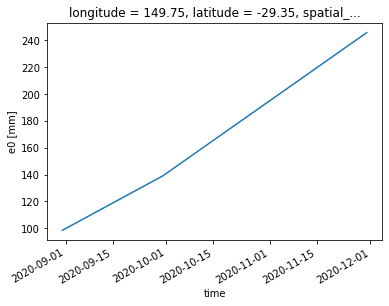

In [18]:
pet = ds_pet.e0.sel(longitude=coords[0], latitude=coords[1], time=ds.time, method="nearest")

pet.plot()

### 15.- Precipitation

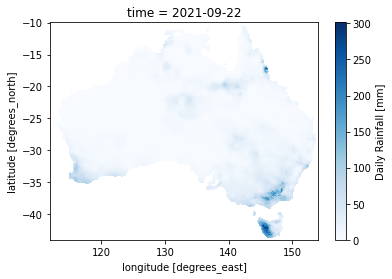

In [19]:
ds_prec = xr.open_dataset("http://www.bom.gov.au/jsp/awra/thredds/dodsC/AWRACMS/values/month/rain_day.nc", decode_times=False)
base = date(1900, 1, 1)
ds_prec['time'] = [np.datetime64(base + timedelta(days=int(x))) for x in ds_prec.time.values]

ds_prec.rain_day.isel(time=-1).plot(cmap="Blues")

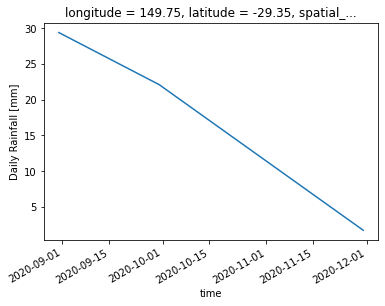

In [20]:
prec = ds_prec.rain_day.sel(longitude=coords[0], latitude=coords[1], time=ds.time, method="nearest")
prec.plot()

### 16.- Finally, lets calculate the Actual Evapotranspiration (AET)

##### AET = kc * PET

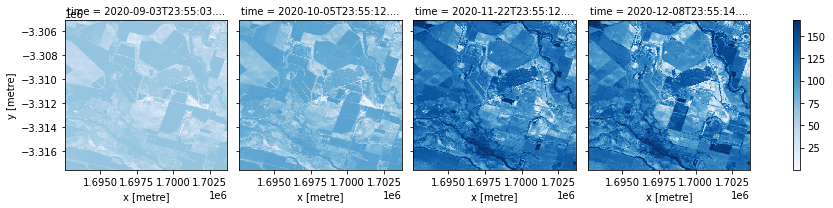

In [21]:
(kc(ds)*pet.values[:,None,None]).plot(col='time', col_wrap=4, cmap="Blues")

### 17.- Plot the temporal evolution over the whole area

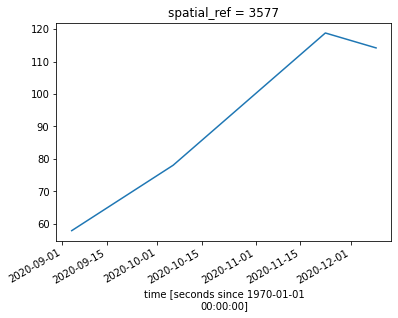

In [22]:
(kc(ds)*pet.values[:,None,None]).mean(dim=["x","y"]).plot()

### 18.- Can you repeat the process for Redbank

In [ ]:
locs = {"Norwood": {"coords": [149.7543738, -29.3741845]},
        "Redbank": {"coords": [150.0313090, -29.4199982]}}

coords = locs["Redbank"]["coords"]

query = {'lat': (coords[1]+0.05, coords[1]-0.05),
         'lon': (coords[0]-0.05, coords[0]+0.05),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 
                          'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
         'time':("2020-09-01", "2021-01-01")}

# Scale values between 0-1
ds = dc.load(product='ga_ls8c_ard_3', group_by='solar_day', **query)/10000

ds[['nbart_red','nbart_green','nbart_blue']].clip(0,0.15).to_array().plot.imshow(col='time', col_wrap=4)

In [23]:
ds = xr.open_dataset("http://www.bom.gov.au/jsp/awra/thredds/dodsC/AWRACMS/values/month/rain_day.nc", decode_times=False)

ds

<xarray.Dataset>
Dimensions:      (latitude: 681, longitude: 841, nv: 2, time: 261)
Coordinates:
  * time         (time) int32 36554 36583 36614 36644 ... 44406 44437 44459
  * longitude    (longitude) float64 112.0 112.0 112.1 ... 153.9 153.9 154.0
  * latitude     (latitude) float64 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) int32 ...
    rain_day     (time, latitude, longitude) float32 ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    var_name:                        rain_day
    title:                           Australian Landscape Water Balance AWRA-...
    Description:                     This data is provided by the Bureau of M...
    summary:                         Data produced by Bureau of Meteorology A...
    source:                          AWRA-L
    date_created:                    2021-09-22T18:59:57
    Conventions:                     CF-1.6, ACDD-1.3
    institution:                     Bureau of Meteorology
    email:                           awrams@bom.gov.au
    url:                             http://www.bom.gov.au/water/landscape
    date_modified:                   2021-09-22T19:01:33
    DODS_EXTRA.Unlimited_Dimension:  time

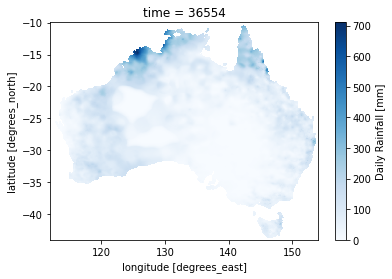

In [24]:
ds.rain_day.isel(time=0).plot(cmap='Blues')